In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Fungsi untuk membuat blok residual
def residual_block(input_tensor, filters, strides=1):
    shortcut = input_tensor

    # First layer
    x = Conv2D(filters[0], (1, 1), strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second layer
    x = Conv2D(filters[1], (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third layer
    x = Conv2D(filters[2], (1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if strides > 1 or input_tensor.shape[-1] != filters[2]:
        shortcut = Conv2D(filters[2], (1, 1), strides=strides, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut and main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


In [ ]:
# Fungsi untuk membuat model ResNet50
def build_resnet50(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Stage 1
    x = residual_block(x, filters=[64, 64, 256], strides=1)
    x = residual_block(x, filters=[64, 64, 256], strides=1)
    x = residual_block(x, filters=[64, 64, 256], strides=1)

    # Stage 2
    x = residual_block(x, filters=[128, 128, 512], strides=2)
    x = residual_block(x, filters=[128, 128, 512], strides=1)
    x = residual_block(x, filters=[128, 128, 512], strides=1)
    x = residual_block(x, filters=[128, 128, 512], strides=1)

    # Stage 3
    x = residual_block(x, filters=[256, 256, 1024], strides=2)
    for _ in range(5):
        x = residual_block(x, filters=[256, 256, 1024], strides=1)

    # Stage 4
    x = residual_block(x, filters=[512, 512, 2048], strides=2)
    x = residual_block(x, filters=[512, 512, 2048], strides=1)
    x = residual_block(x, filters=[512, 512, 2048], strides=1)

    # Output Layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build model
    model = Model(inputs, outputs)
    return model

In [ ]:
# Path ke data training dan testing
train_image_path = '/content/drive/MyDrive/Data_Skripsi_Akhir/Data_Skripsi_Akhir/Coba_Segmentasi/Training'
val_image_path = '/content/drive/MyDrive/Data_Skripsi_Akhir/Data_Skripsi_Akhir/Coba_Segmentasi/Validasi'
test_image_path = '/content/drive/MyDrive/Data_Skripsi_Akhir/Data_Skripsi_Akhir/Coba_Segmentasi/Testing'


In [ ]:

# Image data generator tanpa augmentasi, hanya rescale
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
# Load data training dan testing tanpa augmentasi
train_data = train_datagen.flow_from_directory(
    train_image_path,
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_image_path,
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_image_path,
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical',
    shuffle=False # mencegah pengacakan pada proses prediction yang dapat menyebabkan penebakan tidak sesuai
)

Found 5460 images belonging to 3 classes.
Found 2340 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [ ]:
# Build ResNet50 model
resnet50_model = build_resnet50(input_shape=(224, 224, 3), num_classes=train_data.num_classes)

# Kompilasi model
resnet50_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])


In [ ]:
# Melatih model
history = resnet50_model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=100,                #  jumlah epoch maksimum
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,

)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 2370s 43s/step - accuracy: 0.4730 - loss: 1.1564 - val_accuracy: 0.3326 - val_loss: 4.0195
Epoch 2/100
 1/54 ━━━━━━━━━━━━━━━━━━━━ 41s 781ms/step - accuracy: 0.6900 - loss: 0.6064

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - accuracy: 0.6900 - loss: 0.6064 - val_accuracy: 0.3335 - val_loss: 4.1243
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7272 - loss: 0.5786 - val_accuracy: 0.3309 - val_loss: 11.0269
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step - accuracy: 0.6600 - loss: 0.6873 - val_accuracy: 0.3335 - val_loss: 10.9384
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7176 - loss: 0.5811 - val_accuracy: 0.3326 - val_loss: 25.6994
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 255ms/step - accuracy: 0.7200 - loss: 0.6205 - val_accuracy: 0.3339 - val_loss: 25.5255
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7884 - loss: 0.4515 - val_accuracy: 0.3352 - val_loss: 39.2195
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.7800 - loss: 0.5937 - val_accuracy: 0.3322 - val_loss: 39.5869
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8281 - loss: 0.3919 - val_accuracy: 0.3

In [ ]:
# Simpan history ke file TXT di Google Drive
import json

save_path = '/content/drive/MyDrive/Data_Skripsi_Akhir/Data_Skripsi_Akhir/Coba_Segmentasi/ResNet50_DL_training_history_100epoch.txt'

with open(save_path, 'w') as f:
    json.dump(history.history, f, indent=4)

print(f"Training history saved to '{save_path}'")


Training history saved to '/content/drive/MyDrive/Data_Skripsi_Akhir/Data_Skripsi_Akhir/Coba_Segmentasi/ResNet50_DL_training_history_100epoch.txt'


In [ ]:
# Evaluasi model pada data testing
test_loss, test_acc = resnet50_model.evaluate(test_data)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 22s/step - accuracy: 0.5675 - loss: 3.2447
Test accuracy: 0.6000000238418579
Test loss: 3.1833412647247314


In [ ]:
model_save_path =  '/content/drive/MyDrive/Data_Skripsi_Akhir/Data_Skripsi_Akhir/Coba_Segmentasi/Model_ResNet50/ResNet50_DL_model_S(100_epoch).h5'
resnet50_model.save(model_save_path)
print(f"Model terakhir telah disimpan di: {model_save_path}")

Model terakhir telah disimpan di: /content/drive/MyDrive/Data_Skripsi_Akhir/Data_Skripsi_Akhir/Coba_Segmentasi/Model_ResNet50/ResNet50_DL_model_S(100_epoch).h5


In [ ]:
# Menampilkan summary model
resnet50_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ add[0][0]       

 Total params: 70,675,339 (269.61 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,081,480 (179.60 MB)

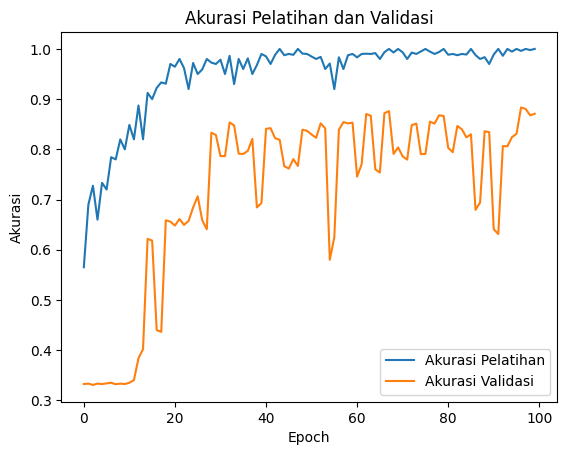

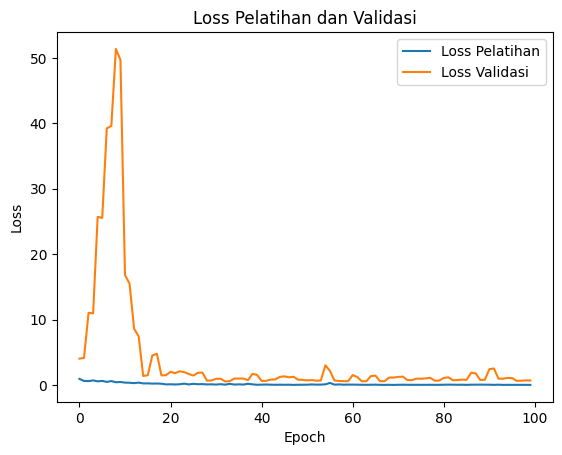

In [ ]:
import matplotlib.pyplot as plt

# Plot Akurasi
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 374ms/step


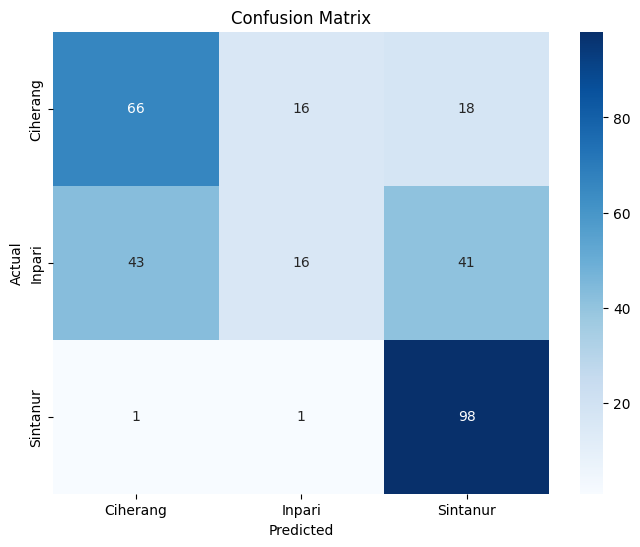

In [ ]:
# --- Tambahkan Confusion Matrix ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Prediksi data validasi
y_pred_probs = resnet50_model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Ambil label sebenarnya
y_true = test_data.classes

# Nama kelas
class_labels = list(test_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

# Laporan klasifikasi (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

    Ciherang       0.60      0.66      0.63       100
      Inpari       0.48      0.16      0.24       100
    Sintanur       0.62      0.98      0.76       100

    accuracy                           0.60       300
   macro avg       0.57      0.60      0.54       300
weighted avg       0.57      0.60      0.54       300

